In [1]:
using GaussianProcesses, SumProductNetworks
using StatsFuns, Distributions, LaTeXStrings, ProgressMeter
using PGFPlots
import SumProductNetworks.add!

INFO: Recompiling stale cache file /raid/user/martint/.julia/lib/v0.6/Clustering.ji for module Clustering.
INFO: Recompiling stale cache file /raid/user/martint/.julia/lib/v0.6/SumProductNetworks.ji for module SumProductNetworks.

Use "abstract type AbstractHyperparam end" instead.

Use "abstract type AbstractModelData end" instead.

Use "abstract type AbstractModelBuffer end" instead.

Use "abstract type ModelType end" instead.

Use "abstract type InitialisationType end" instead.

Use "abstract type PosteriorInference end" instead.

Use "abstract type ConjugatePostDistribution end" instead.

Use "abstract type UnivariateConjugatePostDistribution<:ConjugatePostDistribution end" instead.

Use "abstract type DiscreteUnivariateConjugatePostDistribution<:UnivariateConjugatePostDistribution end" instead.

Use "abstract type ContinuousUnivariateConjugatePostDistribution<:UnivariateConjugatePostDistribution end" instead.

Use "abstract type MultivariateConjugatePostDistribution<:ConjugatePost

In [30]:
Pkg.add("ColorSchemes")

INFO: Installing ColorSchemes v1.5.1
INFO: Building FFTW
INFO: Building SpecialFunctions
INFO: Building ImageMagick
INFO: Package database updated
INFO: METADATA is out-of-date — you may not have the latest version of ColorSchemes
INFO: Use `Pkg.update()` to get the latest versions of your packages


In [31]:
using Colors, ColorSchemes
cm = colormap("grays")
#cm = ColorSchemes.inferno
##println(cm)

INFO: Precompiling module ColorSchemes.


#### include local code

In [14]:
include("utilFunctions.jl")
include("dataTypes.jl")
include("dataTypeUtilFunctions.jl")
include("computationFunctions.jl")
include("regionGraph.jl")
include("regionGraphUtils.jl")
include("gpUtils.jl")

optimize2! (generic function with 1 method)

# Load data

In [27]:
datapath = "../data/clean/motor.csv"
(data, header) = readcsv(datapath, header = true)
headerDict = Dict(col[2] => col[1] for col in enumerate(header))
X = convert(Vector, data[:,headerDict["times"]])
y = convert(Vector, data[:,headerDict["accel"]]);
y /= maximum(y);

In [16]:
reshape(X, 1, length(X))

1×94 Array{Float64,2}:
 2.4  2.6  3.2  3.6  4.0  6.2  6.6  …  50.6  52.0  53.2  55.0  55.4  57.6

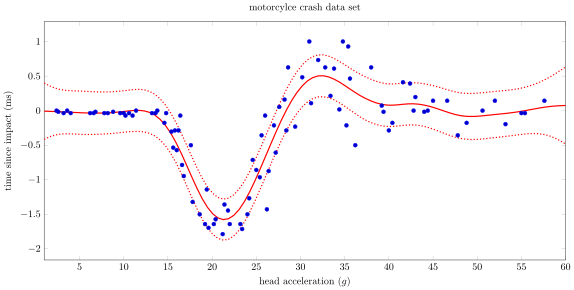

In [17]:
xmin = 1
xmax = 60
S = 100

xx = linspace(xmin,xmax,S)

kernel_function = Mat52Iso(log(5.0), log(1.0))
gp = GP(reshape(X, 1, length(X)), y, MeanZero(), kernel_function, -1.)
optimize2!(gp, mean = false, kern = true, noise = false, lik=false)
μgp, σgp = predict_y(gp,xx);

p = Axis([
        PGFPlots.Linear(X, y, onlyMarks=true, style="blue"),
        PGFPlots.Linear(xx, μgp, mark="none", style="red,very thick"),
        PGFPlots.Linear(xx, μgp + 2*σgp, mark="none", style="red,dotted,very thick"),
        PGFPlots.Linear(xx, μgp - 2*σgp, mark="none", style="red,dotted,very thick")
        ], 
    xlabel=L"head acceleration ($g$)", 
    ylabel="time since impact (ms)", 
    title="motorcylce crash data set",
    width="20cm", height="10cm",
    xmin=xmin, xmax=xmax)

PGFPlots.save("../plots/motorcyle_data_gp.pdf", p)
p

# Construct a region graph

Set some parameters

In [18]:
exp(-1)

0.36787944117144233

In [19]:
global gID = 1

numSums = 1
numGPs = 5
meanFunction = MeanZero();
kernelFunctions = [SE(log(5.0),log(1.0))];
kernelFunctions = [Mat12Iso(log(5.0), log(1.0)), Mat32Iso(log(5.0), log(1.0)), Mat52Iso(log(5.0), log(1.0))]
#kernelFunctions = [LinIso(log(5.0))]
kernelFunctions = [LinIso(log(5.0)), SE(log(5.0),log(1.0))]
noise = -1.;

# put some priors on the parameters
#set_priors!(kernelFunction, [Normal(log(5.0),1.0), Normal(log(1.0),1.0)])

In [46]:
# split size
δ = 10

# data range
minX = 0
maxX = 60

overlap = 0

srand(20)

(rootRegion, sumRegions, gpRegions, allPartitions) = poonDomingos(δ, minX, maxX);
# set IDs for convenients
RegionIDs = Dict(r[2] => r[1] for r in enumerate(union(sumRegions, gpRegions)));
PartitionIDS = Dict(p[2] => p[1] + maximum(values(RegionIDs)) for p in enumerate(allPartitions));
root = convertToSPN(rootRegion, gpRegions, RegionIDs, PartitionIDS, X, y, meanFunction, kernelFunctions, noise; overlap = overlap)

#(rootRegion, sumRegions, gpRegions, allPartitions) = poonDomingos(δ, minX+(δ/2), maxX+(δ/2));
# set IDs for convenients
#RegionIDs = Dict(r[2] => r[1] for r in enumerate(union(sumRegions, gpRegions)));
#PartitionIDS = Dict(p[2] => p[1] + maximum(values(RegionIDs)) for p in enumerate(allPartitions));
#root2 = convertToSPN(rootRegion, gpRegions, X, y, meanFunction, kernelFunctions, noise; overlap = overlap)


Gaussian Process Sum Node [ID: 661, 
	 w_prior: [0.2, 0.2, 0.2, 0.2, 0.2], 
	 w_posterior: [0.2, 0.2, 0.2, 0.2, 0.2]]

# Posterior Inference over SPN-GP

In [21]:
function spn_mcmc(spn::GPSumNode, gpNodes::Vector;
              sampler::Klara.MCSampler=Klara.HMC(),
              nIter::Int = 1000,
              burnin::Int = 0,
              thin::Int = 1)
    
    gps = map(n -> n.gp, gpNodes)
    
    function logpost(hyp::Vector{Float64})  #log-target
        
        for (i, gp) in enumerate(gps)
            p = get_params(gp)
            e = (i*2)
            s = s-1
            p[2:3] = hyp[s:e]
            set_params!(gp, p)
            update_target!(gp)
        end
        
        dirty!(spn)
        spn_update!(spn)
        return spn_posterior(spn)
    end

    function dlogpost(hyp::Vector{Float64}) #gradient of the log-target
        Kgrad_buffer = Array{Float64}(gp.nobsv, gp.nobsv)
        for (i, gp) in enumerate(gps)
            p = get_params(gp)
            e = (i*2)
            s = s-1
            p[2:3] = hyp[s:e]
            set_params!(gp, p)
            update_target_and_dtarget!(gp, noise=false, mean=false, kern=true)
            println(gp.dtarget)
        end
        
        dirty!(spn)
        spn_update!(spn)
        
        return gp.dtarget
    end
    
    start = reduce(vcat, map(gp -> get_params(gp)[2:3], gps))
    starting = Dict(:p=>start)
    q = BasicContMuvParameter(:p, logtarget=logpost, gradlogtarget=dlogpost) 
    model = likelihood_model(q, false)                               #set-up the model
    job = BasicMCJob(model, sampler, BasicMCRange(nsteps=nIter, thinning=thin, burnin=burnin), starting)   #set-up MCMC job
    print(job)                                             #display MCMC set-up for the user
    
    run(job)                          #Run MCMC
    chain = Klara.output(job)         # Extract chain
    #set_params!(gp,start)      #reset the parameters stored in the GP to original values
    return chain
end

spn_mcmc (generic function with 1 method)

In [22]:
#leafs = filter(n -> isa(n, GPLeaf), SumProductNetworks.getOrderedNodes(root))

In [23]:
#spn_mcmc(root, leafs)

## Define root

In [47]:
#root = GPSumNode(nextID(), Int[]);


#for child in children(root1)
#    add!(root, child)
#end

#for child in children(root2)
#    add!(root, child)
#end

fill!(root.prior_weights, 1. / length(root))
fill!(root.posterior_weights, 1. / length(root))

for gpnode in unique(filter(n -> isa(n, GPLeaf), SumProductNetworks.getOrderedNodes(root)))
    iparams = copy(get_params(gpnode.gp.k))
    res = optimize2!(gpnode.gp, mean = false, kern = true, noise = false, lik=false)
end

spn_update!(root)
spn_posterior(root)

-35.69212302111938

## Plotting

In [48]:
xlin = linspace(1, 60)
ylin = linspace(-2, 1.5)

for x_ in xlin
    for y_ in ylin
        @assert !isinf(spn_density(root, x_, y_))
    end
end

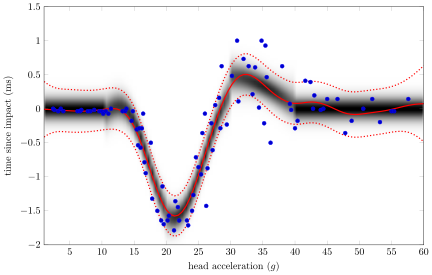

In [49]:
xmin = 1
xmax = 60

ymax = 1.5
ymin = -2

xx = linspace(xmin,xmax,S)
μgp, σgp = predict_y(gp,xx);

p = Axis([
        PGFPlots.Linear(X, y, onlyMarks=true, style="blue"),
        PGFPlots.Image((x,y) -> spn_density(root, x, y), (xmin, xmax), (ymin, ymax), colormap = ColorMaps.RGBArrayMap(cm), colorbar=false),
        
        PGFPlots.Linear(xx, μgp, mark="none", style="red,very thick"),
        PGFPlots.Linear(xx, μgp + 2*σgp, mark="none", style="red,dotted,very thick"),
        PGFPlots.Linear(xx, μgp - 2*σgp, mark="none", style="red,dotted,very thick")
        
        ], 
    xlabel=L"head acceleration ($g$)", 
    ylabel="time since impact (ms)", 
    #title="motorcylce crash data set",
    width="15cm", height="10cm",
    xmin=xmin, xmax=xmax,
    ymin=ymin, ymax=ymax)

#PGFPlots.save("../plots/motorcyle_data_overlap.pdf", p)
p

# demo_epinf.m

In [ ]:
# Create toy data
n = 501;
x = linspace(-100,200,n);

f1 = 5.*sin.(-3+0.2.*x[1:Int(ceil(0.23*n))])
f1 = vcat(f1, 0*sin.(0.1*x[Int(ceil(0.23*n))+1:Int(ceil(0.85*n))]))
f1 = vcat(f1, 5.*sin.(2.8+0.2.*x[Int(ceil(0.85*n))+1:end]))

f1_ = 5.*(-3+0.2.*x[1:Int(ceil(0.23*n))])
f1_ = vcat(f1_, 0*(0.1*x[Int(ceil(0.23*n))+1:Int(ceil(0.85*n))]))
f1_ = vcat(f1_, 5.*(2.8+0.2.*x[Int(ceil(0.85*n))+1:end]))
    
f2 = 100*normpdf.(110, 20, x) + 100*normpdf.(-10, 20, x)
sigma2 = 0.5;

x = x-mean(x)
x = x./std(x)
f1 = f1-mean(f1)
f1 = f1./std(f1)
f1_ = f1_-mean(f1)
f1_ = f1_./std(f1)

y = f1 + sqrt.((sigma2.*exp.(f2))).*randn(size(x))
yt = f1[1:2:end]
xt = x[1:2:end]
nt = size(xt, 1)
x=x[:]*10
y=y[:];
xt=xt[:];

Axis(PGFPlots.Linear(x, y, onlyMarks=true), width="15cm", height="10cm")

In [ ]:
f1_

In [17]:
PGFPlots.Linear(linspace(-20,20,n), f1_, onlyMarks=true)


LoadError: [91mArgumentError: number of rows of each array must match (got (501, 576))[39m

In [6]:
global gID = 1

numSums = 1
numGPs = 5
meanFunction = MeanZero();
kernelFunctions = [LinIso(log(5.0)), Mat32Iso(log(5.0), log(1.0))]
kernelFunctions = [Mat52Iso(log(5.0), log(1.0))]

noise = log(0.7);

# split size
δ = 6

# data range
minX = -20
maxX = 20
overlap = 0

(rootRegion, sumRegions, gpRegions, allPartitions) = poonDomingos(δ, minX, maxX);
# set IDs for convenients
RegionIDs = Dict(r[2] => r[1] for r in enumerate(union(sumRegions, gpRegions)));
PartitionIDS = Dict(p[2] => p[1] + maximum(values(RegionIDs)) for p in enumerate(allPartitions));
root1 = convertToSPN(rootRegion, gpRegions, RegionIDs, PartitionIDS, x, y, meanFunction, kernelFunctions, noise; overlap = overlap)

(rootRegion, sumRegions, gpRegions, allPartitions) = poonDomingos(δ, minX+(δ/2), maxX+(δ/2));
# set IDs for convenients
RegionIDs = Dict(r[2] => r[1] for r in enumerate(union(sumRegions, gpRegions)));
PartitionIDS = Dict(p[2] => p[1] + maximum(values(RegionIDs)) for p in enumerate(allPartitions));
root2 = convertToSPN(rootRegion, gpRegions,  RegionIDs, PartitionIDS,x, y, meanFunction, kernelFunctions, noise; overlap = overlap)

Gaussian Process Sum Node [ID: 281, 
	 w_prior: [0.167, 0.167, 0.167, 0.167, 0.167, 0.167], 
	 w_posterior: [0.167, 0.167, 0.167, 0.167, 0.167, 0.167]]

In [7]:
root = GPSumNode(nextID(), Int[]);


for child in children(root1)
    add!(root, child)
end

for child in children(root2)
    add!(root, child)
end

spn_update!(root1)
spn_posterior(root1)

spn_update!(root2)
spn_posterior(root2)

fill!(root.prior_weights, 1. / length(root))
fill!(root.posterior_weights, 1. / length(root))

for gpnode in unique(filter(n -> isa(n, GPLeaf), SumProductNetworks.getOrderedNodes(root)))
    iparams = copy(get_params(gpnode.gp.k))
    res = optimize2!(gpnode.gp, mean = false, kern = true, noise = true, lik=false)
end

#spn_update!(root)
#spn_posterior(root)

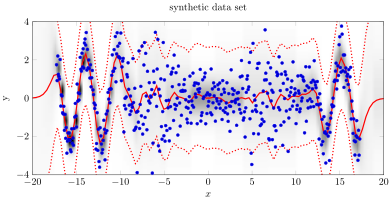

In [111]:
xmin = -2*10
xmax = 2*10

ymax = 4
ymin = -4

xx = linspace(xmin,xmax,S)

kernel_function = Mat52Iso(log(5.0), log(1.0))
gp = GP(reshape(x, 1, length(x)), y, MeanZero(), kernel_function, log(0.7))
optimize2!(gp, mean = false, kern = true, noise = true, lik=false)
μgp, σgp = predict_y(gp,xx);

p = Axis([
        PGFPlots.Linear(x, y, onlyMarks=true, style="blue", markSize=1.5),
        PGFPlots.Image((x,y) -> spn_density(root, x, y), (xmin, xmax), (ymin, ymax), ybins=100, xbins = 100, colormap = ColorMaps.RGBArrayMap(cm), colorbar=false),
        PGFPlots.Linear(xx, μgp, mark="none", style="red,very thick"),
        PGFPlots.Linear(xx, μgp + 2*σgp, mark="none", style="red,dotted,very thick"),
        PGFPlots.Linear(xx, μgp - 2*σgp, mark="none", style="red,dotted,very thick")
        
        ], 
    xlabel=L"x", 
    ylabel="y", 
    title="synthetic data set",
    width="14cm", height="7cm",
    xmin=xmin, xmax=xmax,
    ymin=ymin, ymax=ymax)

PGFPlots.save("../plots/nonstationary_noise_overlap.pdf", p)
p

In [10]:
xx2 = linspace(-20,20,n)
yy = zeros(length(xx2))

for (i,xi) in enumerate(xx2)
    r = Dict{Int, SPNGParamResult}()
    spn_wavelength(root1, xi, r)
    yy[i] = exp(r[root1.id].logsigma)
    
    spn_wavelength(root2, xi, r)
    yy[i] += exp(r[root2.id].logsigma)
    
    yy[i] /= 2
end

#map(x -> spn_wavelength(root, x), xx);

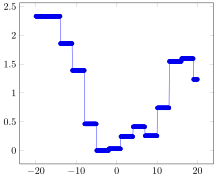

In [11]:
PGFPlots.Linear(xx2, yy[:])

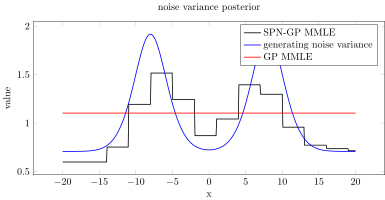

In [113]:
p = Axis([
        PGFPlots.Linear(xx2, yy[:], mark="none", legendentry="SPN-GP MMLE", style="black,thick"),
        PGFPlots.Linear(linspace(-20,20,n), sqrt.((sigma2.*exp.(f2))), mark="none", legendentry="generating noise variance", style="blue,thick"),
        PGFPlots.Linear(linspace(-20,20,n), ones(n) * exp(gp.logNoise), mark="none", legendentry="GP MMLE", style="red,thick")
    ],
    xlabel="x", 
    ylabel="value",
    title="noise variance posterior",
    width="14cm", height="7cm")

PGFPlots.save("../plots/nonstationary_noise_variance.pdf", p)
p

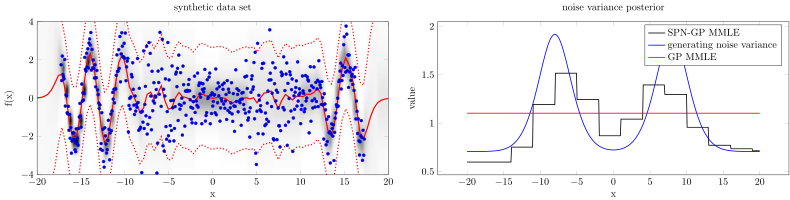

In [109]:
g = GroupPlot(2, 1, groupStyle = "horizontal sep = 1.75cm, vertical sep = 1.75cm")

push!(g, 
    Axis([
        PGFPlots.Linear(x, y, onlyMarks=true, style="blue", markSize=1.5),
        PGFPlots.Image((x,y) -> spn_density(root, x, y), (xmin, xmax), (ymin, ymax), ybins=100, xbins = 100, colormap = ColorMaps.RGBArrayMap(cm), colorbar=false),
        PGFPlots.Linear(xx, μgp, mark="none", style="red,very thick"),
        PGFPlots.Linear(xx, μgp + 2*σgp, mark="none", style="red,dotted,very thick"),
        PGFPlots.Linear(xx, μgp - 2*σgp, mark="none", style="red,dotted,very thick")
        
        ], 
    xlabel="x", 
    ylabel="f(x)", 
    title="synthetic data set",
    width="14cm", height="7cm",
    xmin=xmin, xmax=xmax,
    ymin=ymin, ymax=ymax)
)


push!(g, Axis([
        PGFPlots.Linear(xx2, yy[:], mark="none", legendentry="SPN-GP MMLE", style="black,thick"),
        PGFPlots.Linear(linspace(-20,20,n), sqrt.((sigma2.*exp.(f2))), mark="none", legendentry="generating noise variance", style="blue,thick"),
        PGFPlots.Linear(linspace(-20,20,n), ones(n) * exp(gp.logNoise), mark="none", legendentry="GP MMLE", style="red,thick")
    ],
    xlabel="x", 
    ylabel="value",
    title="noise variance posterior",
    width="14cm", height="7cm"))

PGFPlots.save("../plots/nonstationary_data.pdf", g)
g